In [2]:
library(ggplot2)
library(readxl)
library(tidyverse)
library(ggpubr)
library(scales)
library(cowplot)
library(patchwork)
library(data.table)
library(patchwork)
library(ggvenn)
library(caret)
library(ranger)
library(ROCR) 
library(kernlab)
library(precrec)
library(pROC)
library(broom)
library(glmnet)
library(gbm)
library(xgboost)
library(ggsci)
library(ggplotify)
library(clusterProfiler)
library(pheatmap)

In [3]:
geno <- read.table("03_vcf//snp.matrix.gz",header=T)
samples <- read_excel("03_vcf/samples.xlsx")

In [5]:
load("05_pQTL/snps.Rdata")

In [6]:
Evaluation <- NULL
times <- NULL
for(M in c("rf","glmnet","svmLinear","xgbTree")){
    load(paste0("04_ML/",M,"_evaluation.Rdata"))
    evaluation$Model <- M
    Evaluation <- rbind(Evaluation,evaluation)
    re <- data.frame(Model=M,Seconds)
    times <- rbind(times,re)
}

In [7]:
Evaluation$Model <- factor(Evaluation$Model,labels=c('Elastic Net','RandomForest','SVR','XGBoost'))

Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."


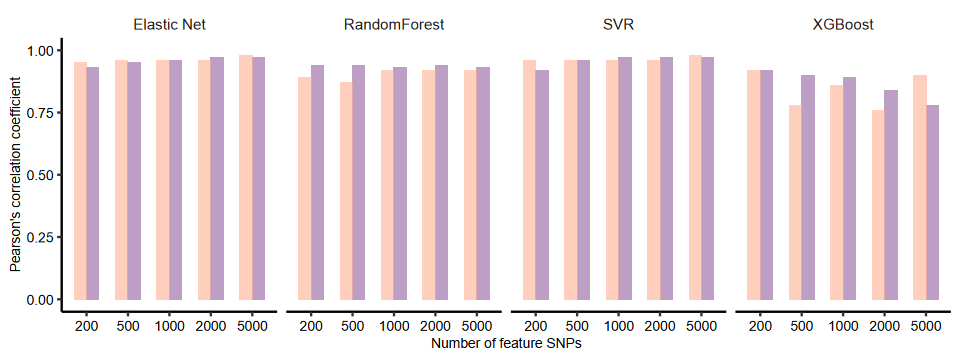

In [8]:
options(repr.plot.width=8, repr.plot.height=3)
Figure2A <- Evaluation %>%
    #dplyr::filter(num>200) %>%
    mutate(num=factor(num)) %>%
    mutate(SNP=type) %>%
    ggplot(aes(num,corr,fill=SNP))+
        geom_bar(stat='identity',position=position_dodge(),width=0.6)+
    theme(axis.text=element_text(size=8,color='black'),
              axis.title=element_text(size=8),strip.background = element_rect(color="white",fill='white'),
              panel.background = element_blank(),
          legend.position="none",
             axis.line = element_line(colour = "black",size = 0.5))+
ylim(0,1)+xlab("Number of feature SNPs")+ylab("Pearson's correlation coefficient")+
scale_fill_manual(values = c("#FDAF9199", "#925E9F99"))+
facet_wrap(~Model,ncol=4)
Figure2A

Don't know how to automatically pick scale for object of type <difftime>. Defaulting to continuous.


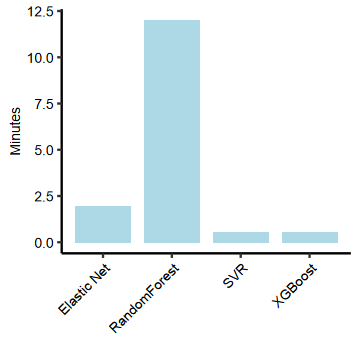

In [9]:
options(repr.plot.width=3, repr.plot.height=3)
Figure2B <- times %>%
    mutate(Model = factor(Model,labels=c('Elastic Net','RandomForest','SVR','XGBoost'))) %>%
    ggplot(aes(Model,Seconds))+
        geom_bar(stat="identity",fill='lightblue',width=0.8)+
    theme(axis.text=element_text(size=8,color='black'),
              axis.title=element_text(size=8),axis.text.x = element_text(size=8,color='black',angle=45,vjust=1,hjust=1),
              panel.background = element_blank(),
          legend.position="none",
             axis.line = element_line(colour = "black",size = 0.5))+
    xlab("")+ylab("Minutes")
Figure2B

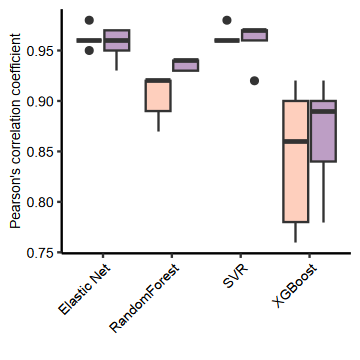

In [10]:
options(repr.plot.width=3, repr.plot.height=3)
Figure2C <- Evaluation %>%
    #dplyr::filter(num>200) %>%
    mutate(SNP=type) %>%
    ggplot(aes(Model,corr,fill=SNP))+
        geom_boxplot(width=0.8)+
    theme(axis.text=element_text(size=8,color='black'),
              axis.title=element_text(size=8),axis.text.x = element_text(size=8,color='black',angle=45,vjust=1,hjust=1),
              panel.background = element_blank(),
          legend.position="none",
             axis.line = element_line(colour = "black",size = 0.5))+
    xlab("")+ylab("Pearson's correlation coefficient")+
scale_fill_manual(values = c("#FDAF9199", "#925E9F99"))
Figure2C

In [11]:
eqtl <- read.table("05_pQTL/F1_pQTL_results.txt",header=T)

In [12]:
val_snps <- read.table("04_ML///pop_snp.matrix",header=T)

In [14]:
samples <- read_excel("03_vcf/samples.xlsx")

In [15]:
Cor <- NULL
for(num in c(200,500,1000,2000,5000)){
    val <- eqtl %>%
        arrange(p.value) %>%
        head(num) %>%
        dplyr::select(CHROM=SNP) %>%
        left_join(val_snps)
    rownames(val) <- val$CHROM
    val <- val[,-1]
    val <- data.frame(Sample=colnames(val),t(val),check.names = F)
    val <- samples %>%
        dplyr::select(Sample,Weight=`Fruit weight (g)`) %>%
        inner_join(val) %>%
        dplyr::select(-Sample) %>%
        as.data.frame(check.names = F)
    val[val=="./."] <- 0
    val[val=="0/0"] <- 0
    val[val=="0/1"] <- 1
    val[val=="1/1"] <- 2
    val[is.na(val)] <- 0
    for(i in 1:ncol(val)){
        val[,i] <- as.numeric(val[,i])
    }
    for(M in c("rf","glmnet","svmLinear","xgbTree")){
        load(paste0("04_ML/",M,"_Model_Top_",num,".RData"))
        predictions <- predict(model, newdata = val)
        results <- data.frame(Actual = (val$Weight),
                          Predicted = predictions)
        corr <- cor.test(results$Actual,results$Predicted)
        corr <- round(corr$estimate,2)
        re <- data.frame(Model=M,num,corr)
        Cor <- rbind(Cor,re)
    }
}

Joining with `by = join_by(CHROM)`
Joining with `by = join_by(Sample)`
Joining with `by = join_by(CHROM)`
Joining with `by = join_by(Sample)`
Joining with `by = join_by(CHROM)`
Joining with `by = join_by(Sample)`
Joining with `by = join_by(CHROM)`
Joining with `by = join_by(Sample)`
Joining with `by = join_by(CHROM)`
Joining with `by = join_by(Sample)`


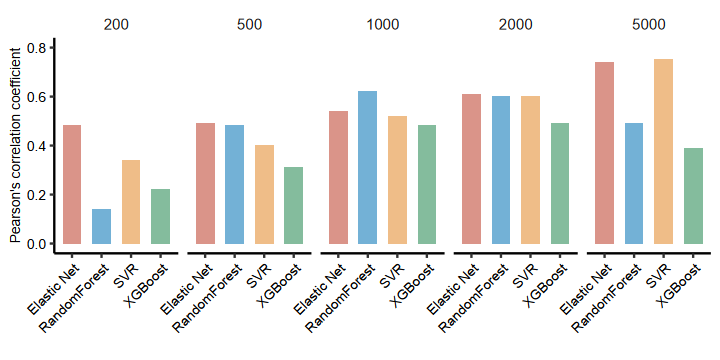

In [16]:
options(repr.plot.width=6, repr.plot.height=3)
Figure2D <- Cor %>%
    mutate(corr=abs(corr)) %>%
    #dplyr::filter(num>200) %>%
    mutate(Model = factor(Model,labels=c('Elastic Net','RandomForest','SVR','XGBoost'))) %>%
    mutate(num=factor(num)) %>%
    ggplot(aes(Model,corr,fill=Model,alpha=0.8))+
        geom_bar(stat='identity',position=position_dodge(),width=0.6)+
    theme(axis.text=element_text(size=8,color='black'),
              axis.title=element_text(size=8),
              panel.background = element_blank(),strip.background = element_rect(color="white",fill='white'),
          legend.position="none",axis.text.x = element_text(size=8,color='black',angle=45,vjust=1,hjust=1),
             axis.line = element_line(colour = "black",size = 0.5))+
ylim(0,0.8)+xlab("")+ylab("Pearson's correlation coefficient")+
facet_wrap(~num,ncol=5)+scale_fill_nejm()
Figure2D

In [17]:
load('04_ML//svmLinear_Model_Top_5000.Rdata')
load("04_ML//Data_Top_5000.Rdata")

In [18]:
predictions <- predict(model, newdata = test)
results <- data.frame(Actual = (test$Weight),
                              Predicted = predictions)

`geom_smooth()` using formula = 'y ~ x'


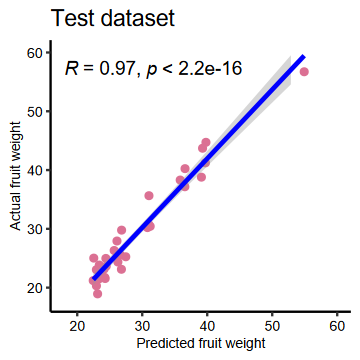

In [19]:
options(repr.plot.width=3, repr.plot.height=3)
Figure2E <- results %>%
    ggplot(aes(Predicted,Actual))+
        geom_point(color='#DB7093')+
    theme(axis.text=element_text(size=8,color='black'),
              axis.title=element_text(size=8),
              panel.background = element_blank(),
          legend.position="none",
             axis.line = element_line(colour = "black",size = 0.5))+
  stat_cor()+
  geom_smooth(method = "lm", se = TRUE,color='blue')+
xlim(18,60)+ylim(18,60)+xlab("Predicted fruit weight")+ylab("Actual fruit weight")+
ggtitle("Test dataset")
Figure2E

In [20]:
for(num in c(5000)){
    val <- eqtl %>%
        arrange(p.value) %>%
        head(num) %>%
        dplyr::select(CHROM=SNP) %>%
        left_join(val_snps)
    rownames(val) <- val$CHROM
    val <- val[,-1]
    val <- data.frame(Sample=colnames(val),t(val),check.names = F)
    val <- samples %>%
        dplyr::select(Sample,Weight=`Fruit weight (g)`) %>%
        inner_join(val) %>%
        dplyr::select(-Sample) %>%
        as.data.frame(check.names = F)
    val[val=="./."] <- 0
    val[val=="0/0"] <- 0
    val[val=="0/1"] <- 1
    val[val=="1/1"] <- 2
    val[is.na(val)] <- 0
    for(i in 1:ncol(val)){
        val[,i] <- as.numeric(val[,i])
    }
    for(M in c("svmLinear")){
        load(paste0("04_ML/",M,"_Model_Top_",num,".RData"))
        predictions2 <- predict(model, newdata = val)
        results2 <- data.frame(Actual = (val$Weight),
                          Predicted = predictions2)
    }
}

Joining with `by = join_by(CHROM)`
Joining with `by = join_by(Sample)`


`geom_smooth()` using formula = 'y ~ x'


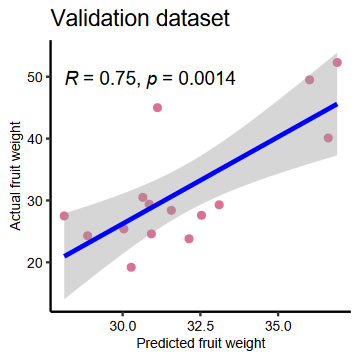

In [21]:
options(repr.plot.width=3, repr.plot.height=3)
Figure2F <- results2 %>%
    ggplot(aes(Predicted,Actual))+
        geom_point(color='#DB7093')+
    theme(axis.text=element_text(size=8,color='black'),
              axis.title=element_text(size=8),
              panel.background = element_blank(),
          legend.position="none",
             axis.line = element_line(colour = "black",size = 0.5))+
  stat_cor()+
  geom_smooth(method = "lm", se = TRUE,color='blue')+
xlab("Predicted fruit weight")+ylab("Actual fruit weight")+
ggtitle("Validation dataset")
Figure2F

In [22]:
feature <- data.frame(SNP=colnames(train)[-1])

In [23]:
feature <- feature %>%
    mutate(CHROM=str_extract(SNP,"(\\w+):")) %>%
    mutate(CHROM=gsub(":","",CHROM)) %>%
    mutate(Pos=str_extract(SNP,":(\\w+)")) %>%
    mutate(Pos=gsub(":","",Pos)) %>%
    mutate(Start=as.numeric(Pos)-1000) %>%
    mutate(End=as.numeric(Pos)+1000) %>%
    mutate(Start=ifelse(Start<0,0,Start)) %>%
    dplyr::select(CHROM,Start,End,SNP)

In [24]:
#write.table(feature,"04_ML/feature.bed",quote=F,row.names=F,col.names=F,sep="\t")

In [25]:
feature_gene <- read.table("04_ML//feature.gene")

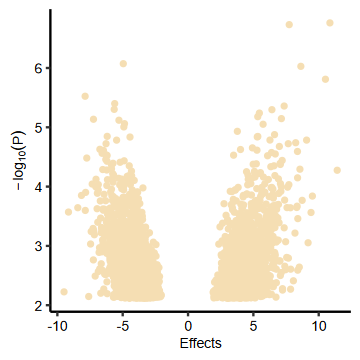

In [26]:
options(repr.plot.width=3, repr.plot.height=3)
Figure2G <- eqtl %>%
        arrange(p.value) %>%
        head(5000) %>%
    ggplot(aes(beta,-log10(p.value)))+
        geom_point(size=1,color='#F5DEB3')+
    theme(axis.text=element_text(size=8,color='black'),
              axis.title=element_text(size=8),
              panel.background = element_blank(),
          legend.position="none",
             axis.line = element_line(colour = "black",size = 0.5))+
  ylab(expression(-log[10](P)))+
xlab("Effects")
Figure2G

Don't know how to automatically pick scale for object of type <difftime>. Defaulting to continuous.
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


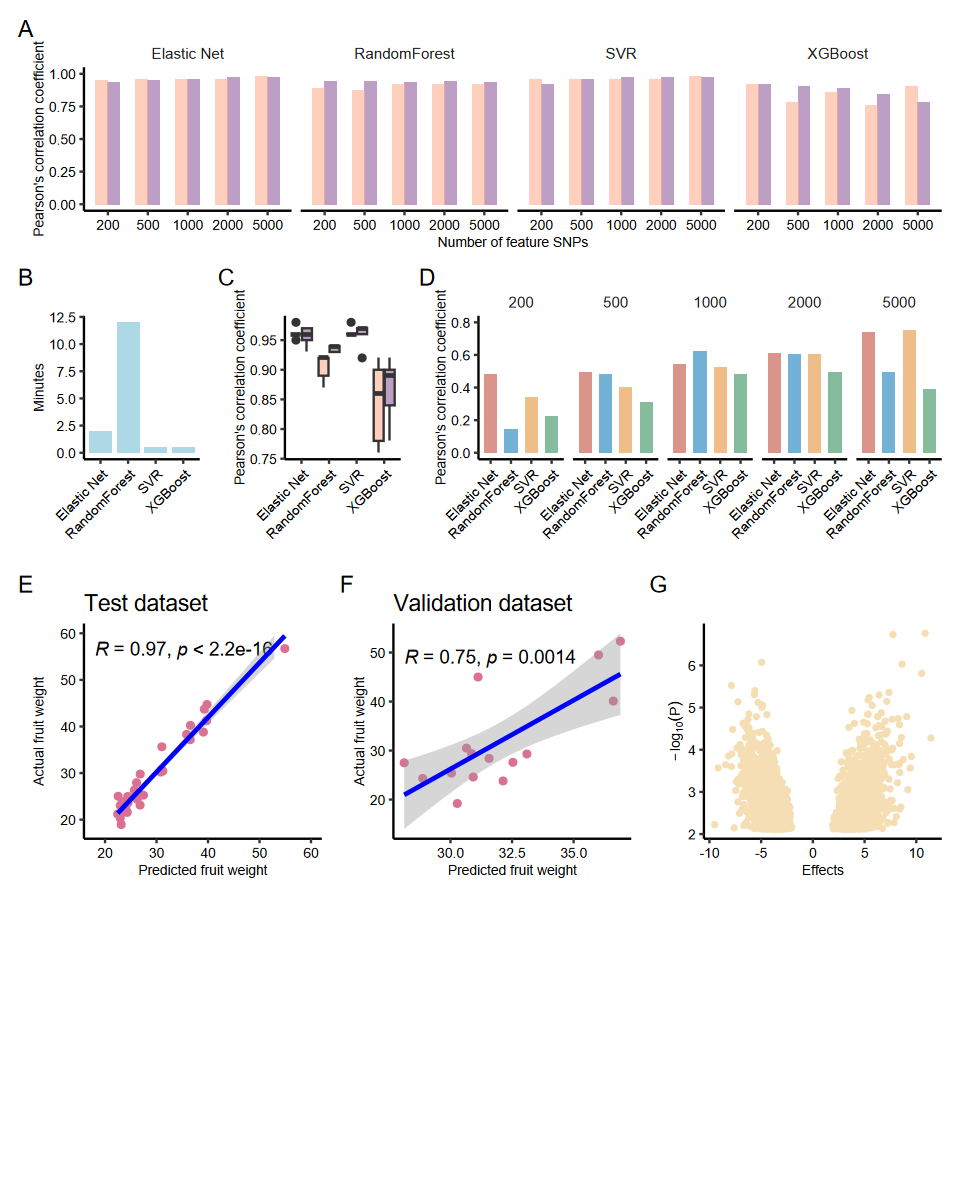

In [27]:
options(repr.plot.width=8, repr.plot.height=10)
((Figure2A/((Figure2B|Figure2C|Figure2D)+plot_layout(widths=c(0.5,0.5,2)))/
(Figure2E|Figure2F|Figure2G)/plot_spacer()))+plot_layout(height=c(1,1,1.5,2))+plot_annotation(tag_levels='A')

In [28]:
#pdf("Figures\\Figure 2.pdf",width=8,height=10)
#((Figure2A/((Figure2B|Figure2C|Figure2D)+plot_layout(widths=c(0.7,0.7,1.6)))/
#(Figure2E|Figure2F|Figure2G)/plot_spacer()))+plot_layout(height=c(1,1,1.5,2))+plot_annotation(tag_levels='A')
#dev.off()

In [29]:
Fst <- read.table("03_vcf//Fst//large_small.windowed.weir.fst",header=T)

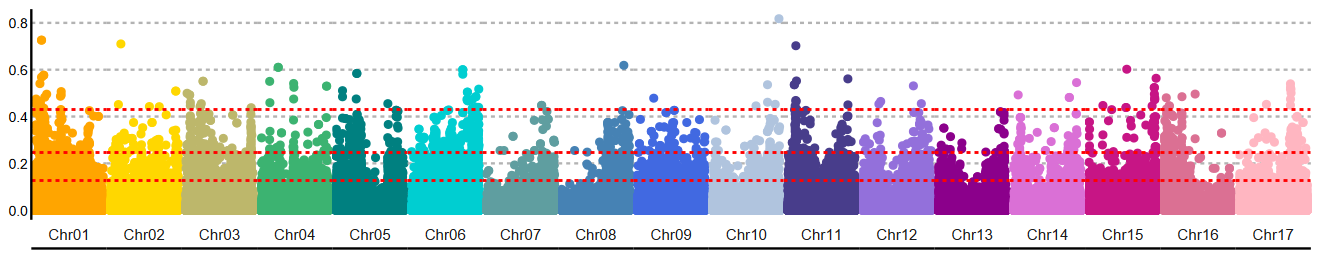

In [30]:
options(repr.plot.width=11, repr.plot.height=2.3)
FigureS2A <- Fst %>%
    mutate(MEAN_FST=ifelse(MEAN_FST<0,0,MEAN_FST)) %>%
    ggplot(aes(BIN_START/1000/1000,MEAN_FST,fill=CHROM,color=CHROM))+
        geom_point()+
    theme_cleveland()+
        facet_wrap(~CHROM,ncol=17,scale='free_x',strip.position="bottom")+
        ylab("Fst (small versus large fruit)")+
        theme(axis.text.x = element_blank(),
             axis.ticks.x = element_blank(),
              axis.text=element_text(size=8,color='black'),
              axis.title=element_text(size=8,color='black'),
             panel.spacing = unit(0,"lines"),strip.background = element_rect(color="white",fill='white'),
                legend.position='none',panel.background = element_blank(),
             axis.line = element_line(colour = "black",size = 0.5))+
        xlab("")+
    scale_color_manual(values =rev(c("#FFB6C1","#DB7093","#C71585","#DA70D6","#8B008B","#9370DB","#483D8B","#B0C4DE",
                            "#4169E1","#4682B4","#5F9EA0","#00CED1","#008080","#3CB371","#BDB76B","#FFD700","#FFA500")))+
geom_hline(yintercept = 0.126209,linetype='dashed',color='red',linewidth=0.6)+
geom_hline(yintercept = 0.247907,linetype='dashed',color='red',linewidth=0.6)+
geom_hline(yintercept = 0.430498,linetype='dashed',color='red',linewidth=0.6)
FigureS2A 

In [31]:
pmap <- read.table("03_vcf//Fst//SS_pmmap.txt")

In [32]:
chrs <- c("Chr03","Chr04","Chr08","Chr12","Chr14","Chr15","Chr16","Chr17")
colors <- c("#BDB76B","#3CB371","#4682B4","#9370DB","#DA70D6","#C71585","#DB7093","#FFB6C1")
pics <- NULL
for(chr in 1:8){
    pic <- Fst %>%
        mutate(MEAN_FST=ifelse(MEAN_FST<0,0,MEAN_FST)) %>%
        dplyr::filter(CHROM==chrs[chr]) %>%
        ggplot(aes(BIN_START/1000/1000,MEAN_FST,fill=CHROM,color=CHROM))
    tmp <- subset(pmap,V1==chrs[chr])
    for(i in 1:nrow(tmp)){
        pic <- pic +
            geom_rect(
            xmin = tmp$V2[i]/1000/1000, xmax = tmp$V3[i]/1000/1000,
            ymin = -Inf, ymax = Inf,
            fill = "lightblue", alpha = 0.2,
            color = NA)        
    }

    pic <- pic + 
        geom_point(size=0.5)+
        theme_cleveland()+
        facet_wrap(~CHROM,ncol=17,scale='free_x',strip.position="bottom")+
            ylab("Fst")+
            theme(axis.text.x = element_blank(),
                 axis.ticks.x = element_blank(),
                  axis.text=element_text(size=8,color='black'),
                  axis.title=element_text(size=8,color='black'),
                 panel.spacing = unit(0,"lines"),strip.background = element_rect(color="white",fill='white'),
                    legend.position='none',panel.background = element_blank(),
                 axis.line = element_line(colour = "black",size = 0.5))+
            xlab("")+
        scale_color_manual(values =colors[chr])+ylim(0,0.65)
    pics[[chr]] <- pic
}

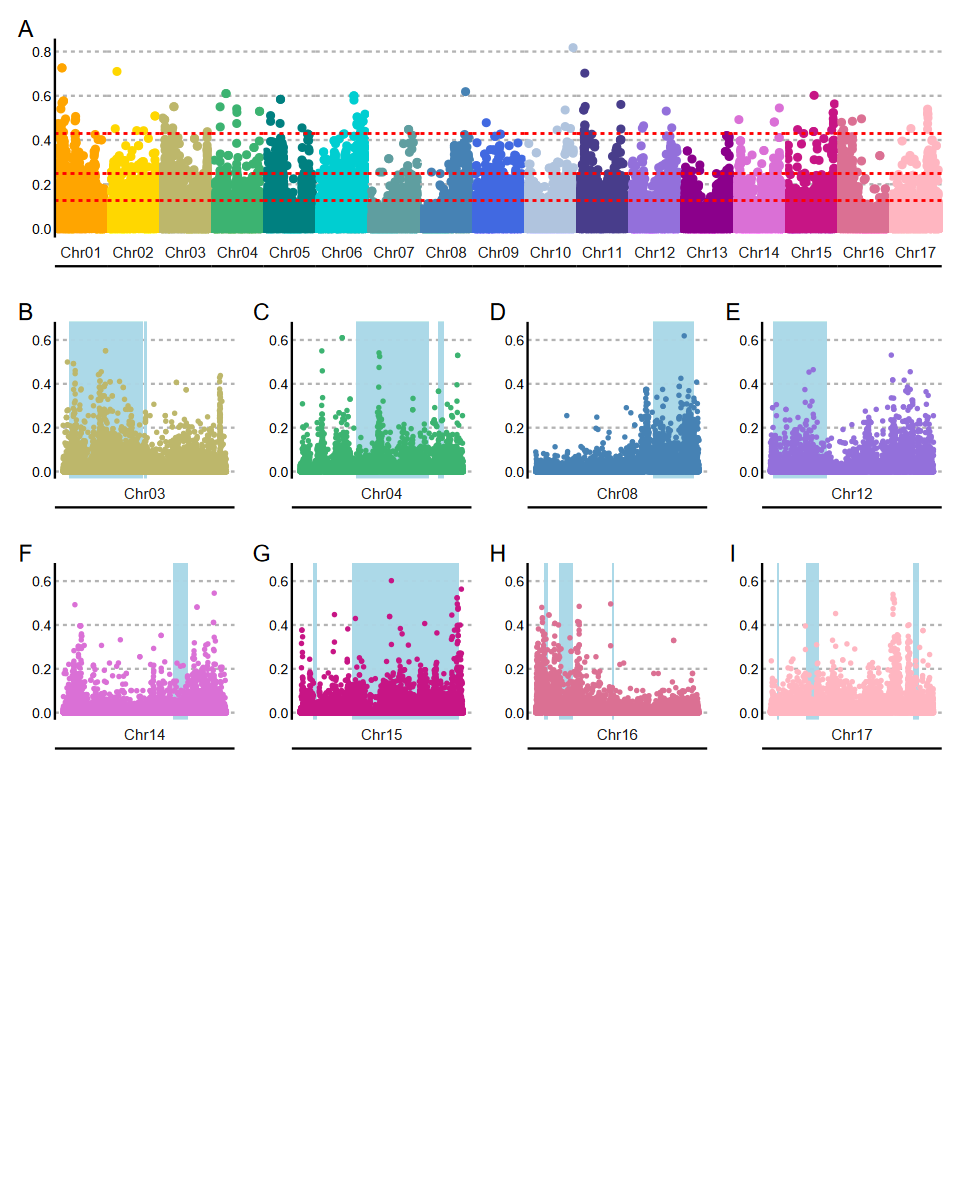

In [33]:
options(repr.plot.width=8, repr.plot.height=10)
(FigureS2A/wrap_plots(pics, ncol = 4)/plot_spacer())+plot_layout(height=c(1,2,2))+plot_annotation(tag_levels='A')

In [34]:
#pdf("Figures\\Figure S2.pdf",width=8,height=10)
#(FigureS2A/wrap_plots(pics, ncol = 4)/plot_spacer())+plot_layout(height=c(1,2,2))+plot_annotation(tag_levels='A')
#dev.off()